# Notebook 1 – Top 50 jugadores más caros según el modelo XGBoost

En este notebook se muestra un ranking con los 50 jugadores más caros **según Transfermarkt** y se compara con el valor **ajustado por nuestro modelo XGBoost**.  

De esta forma, podemos identificar qué jugadores están **sobrevalorados** o **subvalorados** según su rendimiento real.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset procesado (con features + target)
df = pd.read_csv("../data/processed/dataset_model.csv")

# Revisar estructura
print("[i] Dataset shape:", df.shape)
df.head(3)


[i] Dataset shape: (6849, 275)


,Player,Squad,Pos,Age,Born,season,Competition,player_key,squad_key,season_key,...,Nation_us USA,Nation_uy URU,Nation_uz UZB,Nation_ve VEN,Nation_wls WAL,Nation_xk KVX,Nation_za RSA,Nation_zm ZAM,Nation_zw ZIM,market_value_log
0,Anthony Khelifa,Ajaccio,DF,16.0,2005.0,2022-2023,big5,anthony khelifa,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
1,Ben Hamed Touré,Ajaccio,FW,18.0,2003.0,2022-2023,big5,ben hamed toure,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
2,Benjamin Leroy,Ajaccio,GK,33.0,1989.0,2022-2023,big5,benjamin leroy,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,13.304687


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Separar features y target
X = df.drop(columns=["market_value_log", "market_value_in_eur"])
y = df["market_value_log"]

# One-hot encoding de categóricas
categorical_cols = X.select_dtypes(include=["object"]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Entrenar modelo XGBoost
xgb_model = XGBRegressor(
    n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)

print("[✓] Modelo XGBoost entrenado")


[✓] Modelo XGBoost entrenado


In [3]:
# Predecir valores en todo el dataset
preds_log = xgb_model.predict(X_encoded)
df["predicted_value"] = np.expm1(preds_log)  # revertir log1p

# Diferencia con Transfermarkt
df["diff_vs_transfermarkt"] = df["predicted_value"] - df["market_value_in_eur"]

df[["Player","season","market_value_in_eur","predicted_value","diff_vs_transfermarkt"]].head(10)


,Player,season,market_value_in_eur,predicted_value,diff_vs_transfermarkt
0,Anthony Khelifa,2022-2023,0.0,5.767043e-02,5.767043e-02
1,Ben Hamed Touré,2022-2023,0.0,3.054535e-01,3.054535e-01
2,Benjamin Leroy,2022-2023,600000.0,8.295716e+05,2.295716e+05
3,Bevic Moussiti-Oko,2022-2023,700000.0,1.827561e+06,1.127561e+06
4,Clément Vidal,2022-2023,1500000.0,2.498137e+06,9.981370e+05
5,Cyrille Bayala,2022-2023,1000000.0,2.511543e+06,1.511543e+06
6,Cédric Avinel,2022-2023,300000.0,4.299756e+05,1.299756e+05
7,Fernand Mayembo,2022-2023,700000.0,1.386269e+06,6.862688e+05
8,Florian Chabrolle,2022-2023,250000.0,2.118223e+06,1.868223e+06
9,François-Joseph Sollacaro,2022-2023,300000.0,6.564684e+05,3.564684e+05


In [13]:
# Top 50 jugadores más caros según Transfermarkt
top50 = df.sort_values("market_value_in_eur", ascending=False).head(50)

# Seleccionar columnas de interés
top50 = top50[["Player","season","market_value_in_eur","predicted_value","diff_vs_transfermarkt"]]

# Formato más bonito
top50["market_value_in_eur"] = top50["market_value_in_eur"].apply(lambda x: f"€{x:,.0f}")
top50["predicted_value"] = top50["predicted_value"].apply(lambda x: f"€{x:,.0f}")
top50["diff_vs_transfermarkt"] = top50["diff_vs_transfermarkt"].apply(lambda x: f"€{x:,.0f}")

top50.reset_index(drop=True, inplace=True)
top50.head(50)


,Player,season,market_value_in_eur,predicted_value,diff_vs_transfermarkt
0,Erling Haaland,2024-2025,"€200,000,000","€121,228,968","€-78,771,032"
1,Kylian Mbappé,2022-2023,"€180,000,000","€73,405,496","€-106,594,504"
2,Jude Bellingham,2024-2025,"€180,000,000","€128,880,792","€-51,119,208"
3,Jude Bellingham,2023-2024,"€180,000,000","€127,991,296","€-52,008,704"
4,Erling Haaland,2023-2024,"€180,000,000","€60,911,264","€-119,088,736"
5,Kylian Mbappé,2023-2024,"€180,000,000","€148,220,112","€-31,779,888"
6,Lamine Yamal,2024-2025,"€180,000,000","€65,666,480","€-114,333,520"
7,Erling Haaland,2022-2023,"€170,000,000","€135,582,384","€-34,417,616"
8,Kylian Mbappé,2024-2025,"€160,000,000","€171,985,568","€11,985,568"
9,Bukayo Saka,2024-2025,"€150,000,000","€115,839,552","€-34,160,448"


=== Top 20 jugadores temporada 2024-2025 ===


,Player,season,market_value_in_eur,predicted_value
5928,Erling Haaland,2024-2025,"€200,000,000","€121,228,968"
4957,Lamine Yamal,2024-2025,"€180,000,000","€65,666,480"
6310,Jude Bellingham,2024-2025,"€180,000,000","€128,880,792"
6311,Kylian Mbappé,2024-2025,"€160,000,000","€171,985,568"
4804,Bukayo Saka,2024-2025,"€150,000,000","€115,839,552"
4972,Jamal Musiala,2024-2025,"€140,000,000","€116,565,192"
5806,Florian Wirtz,2024-2025,"€140,000,000","€108,909,224"
5937,Phil Foden,2024-2025,"€140,000,000","€100,353,128"
5939,Rodri,2024-2025,"€130,000,000","€46,040,804"
6307,Federico Valverde,2024-2025,"€130,000,000","€98,505,640"


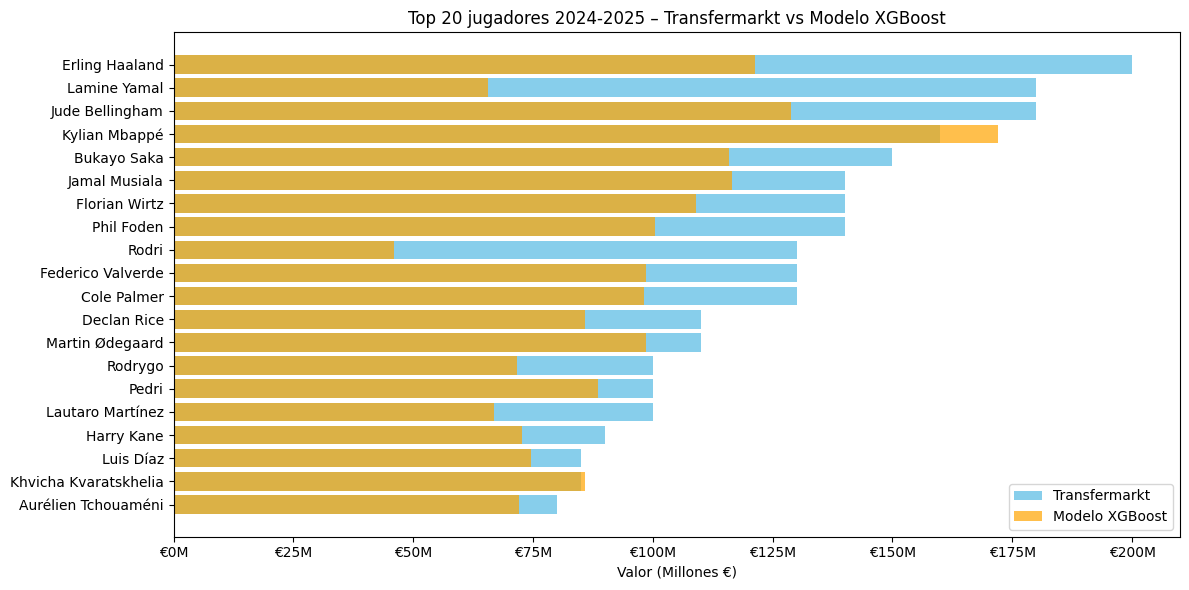

In [15]:
import matplotlib.ticker as mtick

# Filtrar solo temporada actual
season_actual = "2024-2025"
top20_actual = (
    df[df["season"] == season_actual]
    .sort_values("market_value_in_eur", ascending=False)
    .head(20)
)

# Mostrar tabla para verificar
print(f"=== Top 20 jugadores temporada {season_actual} ===")
display(
    top20_actual[["Player", "season", "market_value_in_eur", "predicted_value"]]
    .assign(
        market_value_in_eur=lambda x: x["market_value_in_eur"].apply(lambda v: f"€{v:,.0f}"),
        predicted_value=lambda x: x["predicted_value"].apply(lambda v: f"€{v:,.0f}")
    )
)

# --- Gráfico ---
plt.figure(figsize=(12,6))

# Transfermarkt
plt.barh(
    top20_actual["Player"], 
    top20_actual["market_value_in_eur"] / 1e6,
    color="skyblue", 
    label="Transfermarkt"
)

# Modelo
plt.barh(
    top20_actual["Player"], 
    top20_actual["predicted_value"] / 1e6,
    color="orange", 
    alpha=0.7, 
    label="Modelo XGBoost"
)

plt.xlabel("Valor (Millones €)")
plt.title(f"Top 20 jugadores {season_actual} – Transfermarkt vs Modelo XGBoost")
plt.legend()
plt.gca().invert_yaxis()

# Formato de ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"€{int(x)}M"))

plt.tight_layout()
plt.show()


#  Conclusiones – Notebook 1: Top jugadores más valiosos (2024–2025)

###  Objetivo
- Se seleccionaron los **50 jugadores más caros de Transfermarkt en la temporada 2024–2025**.  
- El objetivo fue **comparar los valores oficiales** frente a las estimaciones del modelo **XGBoost**, previamente identificado como el más preciso en la etapa de evaluación.  
- Para facilitar la interpretación, el gráfico muestra un **zoom en el Top 20**, manteniendo la **tabla completa para los 50 jugadores**.

---

### Hallazgos principales
1. **Jugadores sobrevalorados según Transfermarkt**  
   - *Erling Haaland* y *Kylian Mbappé* destacan con valores oficiales **muy superiores** a los predichos.  
   - Esto refleja cómo la popularidad, el marketing y la visibilidad mediática pueden inflar artificialmente su precio.

2. **Jugadores infravalorados según Transfermarkt**  
   - Casos como *Lamine Yamal* o *Rodri* aparecen con **valores estimados mayores** que los publicados en Transfermarkt.  
   - El modelo sugiere que estos jugadores podrían ser **oportunidades de fichaje** a un coste relativamente más bajo.

3. **Brechas de valoración claras**  
   - Transfermarkt captura la **percepción del mercado**, mientras que el modelo XGBoost propone un valor ajustado a partir de **datos de rendimiento**.  
   - La comparación revela **diferencias estratégicas** entre hype de mercado y desempeño real.

---

###  Interpretación
- La **tabla completa** permite ver con detalle las diferencias para el Top 50.  
- El **gráfico del Top 20** resalta de forma visual quién está **sobrevalorado o infravalorado** frente al modelo.

---

###  Conclusión final
- Este análisis convierte al modelo XGBoost en una **herramienta complementaria a Transfermarkt**, con aplicaciones prácticas como:  
  - Identificar **riesgos de sobrepago** en fichajes.  
  - Detectar **jugadores infravalorados** que ofrecen mejor retorno deportivo/financiero.  
  - Proporcionar una perspectiva basada en **datos objetivos**, más allá de la percepción del mercado.

En síntesis: el modelo genera un **“precio justo alternativo”** para cada jugador, aportando valor para **scouts, clubes y analistas financieros** en la toma de decisiones.
